# TS7: Filtrado digital lineal de ECG


Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

*Ayuda*: Los detalles de cómo acceder a ecg.mat los pueden encontrar en lectura_sigs.py




In [ ]:
#Librarias y funciones
import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd

from pytc2.sistemas_lineales import plot_plantilla, group_delay

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N=len(ecg_one_lead)
fs=1000 #Hz

Para poder filtrar el archivo del ECG, se decidio hacer un filtro pasa banda con 2 frecuencias de paso. Dichos valores los voy a tomar de la tarea semanal 5, donde el ancho de banda esta rondonda entre 1 y 35 Hz.

Luego para evitar ruidos de baja frecuencia originados por movientos musculares, respiratorios, de componentes electronicos del dispositivo, entonces se propuso poner una frecuencia de corte de 0.1 Hz y otra de 50Hz.

Ambas tuplas fueron normalizados mediante la Nyquist = 1

In [ ]:
aprox_name = 'butter'
fs_nyq= 1 #Hz Normalizada

# Especificaciones del filtro bandpass
fpass = np.array( [.01, 0.35] ) 
fstop = np.array( [.001, 0.5] )
ripple= 1 #dB
attenuation = 40 #dB

# Matriz de coeficientes del filtro en formato SOS 
my_sos= sig.iirdesign(fpass,fstop,ripple,attenuation,fs=fs,ftype=aprox_name,output='sos')

# Para mejorar la resolucion de la frecuencia, se puede aumentar el número de puntos
w_rad = np.append(np.logspace(-2,0.8,250), np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad, np.linspace(40,fs_nyq,500,endpoint=True))/fs_nyq * np.pi

# Mostrar la matriz SOS de forma estética usando pandas
sos_df = pd.DataFrame(my_sos, columns=['b0', 'b1', 'b2', 'a0', 'a1', 'a2'])
display(sos_df.style.format("{:.6f}").set_caption("Coeficientes del filtro (SOS)"))




,b0,b1,b2,a0,a1,a2
0,0.000000,0.000000,0.000000,1.000000,-1.995756,0.995761
1,1.000000,2.000000,1.000000,1.000000,-1.996034,0.996039
2,1.000000,2.000000,1.000000,1.000000,-1.996484,0.996489
3,1.000000,2.000000,1.000000,1.000000,-1.997088,0.997094
4,1.000000,2.000000,1.000000,1.000000,-1.997821,0.997826
5,1.000000,2.000000,1.000000,1.000000,-1.998650,0.998655
6,1.000000,2.000000,1.000000,1.000000,-1.999540,0.999545
7,1.000000,0.000000,-1.000000,1.000000,-1.997768,0.997768
8,1.000000,-2.000000,1.000000,1.000000,-1.999876,0.999876
9,1.000000,-2.000000,1.000000,1.000000,-1.999886,0.999886


Explicacion de la matriz de coeficientes: 

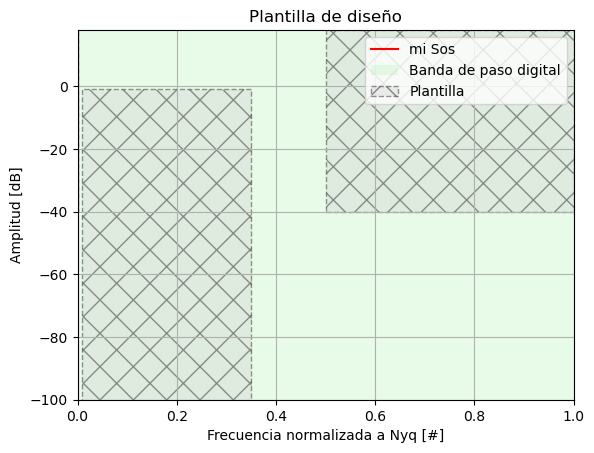

In [38]:
#Grafico mi plantilla
plt.figure(1)
plt.cla()

w,hh= sig.sosfreqz(my_sos, worN=w_rad ,fs=2) # Para obtener la grilla de frecuencia y el valor del modulo
plt.plot(w/np.pi, 20*np.log10(np.abs(hh)), label='mi Sos',color='red') # Respuesta de Modulo
plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plt.gca().set_xlim([0, 1])
plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
plt.legend()

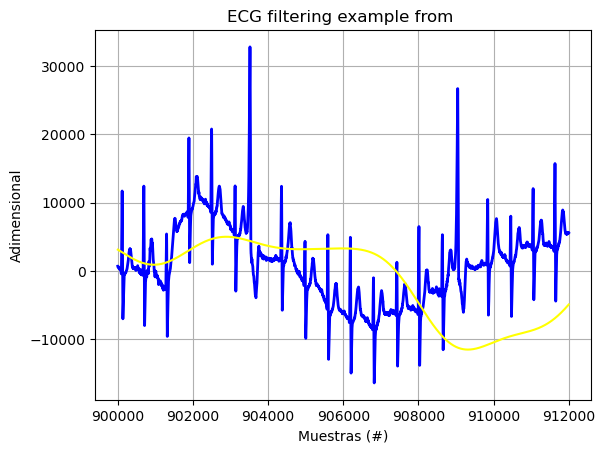

In [39]:
# Filtrado del ECG 

y_ecg = sig.sosfilt(my_sos, ecg_one_lead,axis=0)
reg_interes =  np.array([15, 15.2]) *60*fs

# Asegurar que los índices estén dentro del rango válido
reg_interes[0] = max(0, reg_interes[0])
reg_interes[1] = min(N, reg_interes[1])

zoom_region = np.arange(reg_interes[0], reg_interes[1], dtype='int')

plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2,color='blue')
plt.plot(zoom_region, y_ecg[zoom_region], label='Win',color='yellow')
plt.title('ECG filtering example from ')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.grid()